In [38]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import cmocean as cmo 

dst = xr.open_dataset("population_dataset_time.nc")

N = len(dst.kappa)
NT = len(dst.t)


hr2s = 1/3600
wm = 0.5 * hr2s
wd = 0.05 * hr2s
n2 = 1e-4
Ld = 0.006 * hr2s
Lm  = 0.004 * hr2s
growth_m = 0.05 * hr2s
growth_d = 0.008 * hr2s
colors = [ "#F2B707",  "#9F22F2", "#BF0F0F"]


In [2]:
# Functions
def steady_state(H, R, kappa, d2, m2, n1):

    # Solution 1:
    d1 = -d2*kappa/(-H*Ld*R + H*R*growth_d*n1 - kappa - wd)
    m1 = (-kappa*m2 - m2*wm)/(-H*Lm*R + H*R*growth_m*n1 - kappa)
    return (d1, m1)


def field_at_point(R, H, kappa, m1, m2, d1, d2, n1, n2):
    h1 = R*H 
    h2 = H - h1     
         
    #       advection        diffusion       loss      growth
    f1 =  (wm/h1)*m2  + kappa/h1 * (m2 - m1) - Lm*m1 + growth_m*n1*m1    # surface Microcystis
    f2 = (-wm/h2)*m2  + kappa/h2 * (m1 - m2) - Lm*m2                     # bottom Microcystis
    f3 = (-wd/h1)*d1  + kappa/h1 * (d2 - d1) - Ld*d1 + growth_d*n1*d1      # surface diatoms
    f4 = ( wd/h2)*d1  + kappa/h2 * (d1 - d2) - Ld*d2                       # bottom diatoms 
    f5 = kappa/h1 * (n2 - n1) - (m1*growth_m)*n1  - (d1*growth_d)*n1 

    return f1, f2, f3, f4, f5


def jacobian(kappa, h1, h2, m1, m2, d1, d2, n1):
    j = np.array([[(-kappa/h1 + growth_m*n1 - Lm),  (kappa/h1 + wm/h1),     0,      0,    growth_m*m1],
                    [kappa/h2,  (-wm/h2 - kappa/h2 - Lm),   0,     0,        0],
                    [0, 0,  (-wd/h1 - kappa/h1 + growth_d*n1 - Ld),     kappa/h1,   growth_d*d1],
                    [0,   0,  (wd/h2 + kappa/h2),     (-kappa/h2 - Ld),   0],
                    [-growth_m*n1,     0,  -growth_d*n1,    0,  (-kappa/h1 - growth_d*d1 - growth_m*m1)]])
    eigenvalues, eigenvectors = np.linalg.eig(j)
    # eigenvalues = np.linalg.eigvals(j)

    # Sort by eigenvalue 
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return (eigenvalues, eigenvectors)      

Depth = 6.00 m, R = 0.6, $\kappa$=7.2e-04


<>:15: SyntaxWarning: invalid escape sequence '\k'
<>:15: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_101360/3114125461.py:15: SyntaxWarning: invalid escape sequence '\k'
  txt = "Depth = %2.2f m, R = %2.1f, $\kappa$=%2.1e" % (depth, ratio, kappa)
/tmp/ipykernel_101360/3114125461.py:59: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim(0, 1e-3)


Text(0.5, 0, 'Time (hours)')

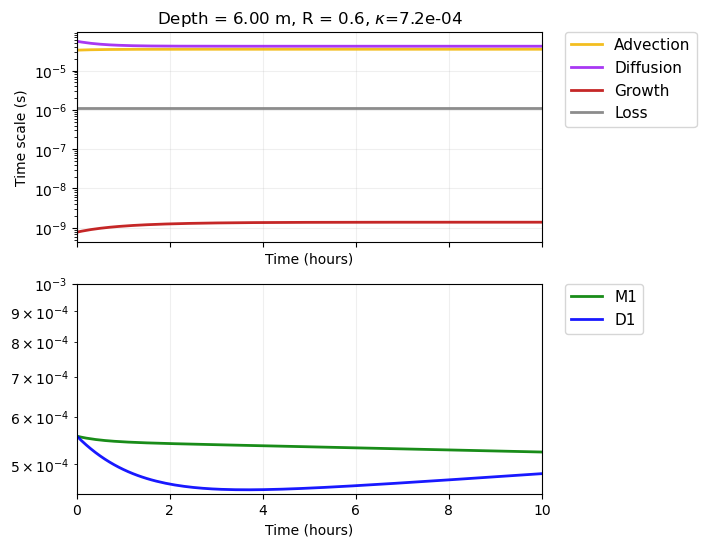

In [44]:
# Snapshot of three time frames 
TIMES = list(range(0, 300, 20)) 

id = 4
ir = 8
ik = 5 
kappa = dst.kappa.values[ik]
# Depth = 5.00 m, R = 0.6, Kappa = 2e-04 (interesting)
depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
h1 = ratio * depth
h2 = depth - h1

# txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
txt = "Depth = %2.2f m, R = %2.1f, $\kappa$=%2.1e" % (depth, ratio, kappa)
print(txt)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)


shapes = ['o', 's', '^', 'x', 'v']
shapes = ['o', 'o', 'o', 'o', 'o']

variables = ["M_1", "M_2", "D_1", "D_2", "N_1"]
axs[0].grid(alpha=0.2)
# ax.legend()
axs[0].set_title(txt)
axs[0].axhline(y=0, color='k', alpha=0.5)
axs[0].axvline(x=0, color='k', alpha=0.5)
axs[0].set_ylabel("Time scale (s)")
axs[0].set_xlabel("Time (hours)")

hours = dst.t.values/3600
d1 = dst.d1.values[:, id ,ir, ik]
d2 = dst.d2.values[:, id ,ir, ik] # (time, depth, ratio, kappa) 
m1 = dst.m1.values[:, id ,ir, ik]
m2 = dst.m2.values[:, id ,ir, ik]
n1 = dst.n1.values[:, id ,ir, ik]
   
gamma = m1/m2 
advection_time_scale_m1 = wm/(h1 * gamma)  * np.ones(len(hours)) 
diffusion_time_scale_m1 = kappa/(h1) * gamma * abs(1/gamma - 1) 
growth_time_scale_m1 = growth_m * n1
loss_time_scale_m1 = Lm*np.ones(len(hours))

axs[0].plot(hours, advection_time_scale_m1, '-', color=colors[0], alpha=0.9, label="Advection", linewidth=2  )
axs[0].plot(hours, diffusion_time_scale_m1, '-', color=colors[1], alpha=0.9, label="Diffusion", linewidth=2  )
axs[0].plot(hours, growth_time_scale_m1, '-', color=colors[2], alpha=0.9, label="Growth", linewidth=2  )
axs[0].plot(hours, loss_time_scale_m1, '-', color='gray', alpha=0.9, label="Loss", linewidth=2  )

     
axs[0].legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11)
axs[0].set_xlim(0,10)
axs[0].set_yscale('log')

axs[1].plot(hours, m1, '-', color='green', alpha=0.9, label="M1", linewidth=2 )
axs[1].plot(hours, d1, '-', color='blue', alpha=0.9, label="D1", linewidth=2 )
axs[1].set_yscale('log')
axs[1].set_ylim(0, 1e-3)
axs[1].legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11)
axs[1].grid(alpha=0.2)
axs[1].set_xlabel("Time (hours)")

<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_101360/1313201853.py:31: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Re($\lambda$)")


Depth = 6.19 m, R = 0.5


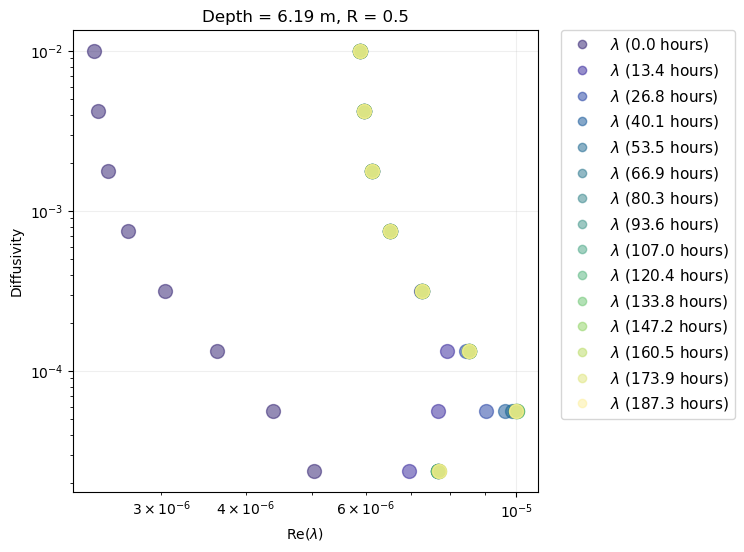

In [4]:
# Snapshot of three time frames 
TIMES = list(range(0, 300, 20)) 

id = 5
ir = 8

# Depth = 5.00 m, R = 0.6, Kappa = 2e-04 (interesting)
depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
h1 = ratio * depth
h2 = depth - h1

# txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
txt = "Depth = %2.2f m, R = %2.1f" % (depth, ratio)
print(txt)

fig = plt.figure(figsize=(6,6))
ax = plt.gca()


shapes = ['o', 's', '^', 'x', 'v']
shapes = ['o', 'o', 'o', 'o', 'o']

variables = ["M_1", "M_2", "D_1", "D_2", "N_1"]
ax.grid(alpha=0.2)
# ax.legend()
ax.set_title(txt)
ax.axhline(y=0, color='k', alpha=0.5)
ax.axvline(x=0, color='k', alpha=0.5)
ax.set_ylabel("Diffusivity")
ax.set_xlabel("Re($\lambda$)")

for ik in range(0, 15, 2):
    kappa = dst.kappa.values[ik]
        
    for it in TIMES: 
        hour = dst.t.values[it]/3600
        d1 = dst.d1.values[it, id ,ir, ik]
        d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
        m1 = dst.m1.values[it, id ,ir, ik]
        m2 = dst.m2.values[it, id ,ir, ik]
        n1 = dst.n1.values[it, id ,ir, ik]
        eigenvalues, ev = jacobian(kappa, h1, h2, m1, m2, d1, d2, n1)
        for e, eig in enumerate(eigenvalues):
            if eig.real < 0:
                eigenvalues[e] = -eig
                ev[e] = -ev[e]
            
        eigenvalues = sorted(eigenvalues)
        vector0 = np.array([m1, m2, d1, d2, n1])
        color = cmo.cm.haline(it/max(TIMES))

        for ie, eigenvalue in enumerate(eigenvalues[1:2]):
            # if eigenvalue.real<0:
            #     vector0 = -vector
            # else:
            #     vector0 = vector
            ev0 = ev[ie]/ np.linalg.norm(ev[ie])
            vector0 = vector0/ np.linalg.norm(vector0)
            if ((it%1) == 0):
                ax.plot(abs(eigenvalue.real), kappa, shapes[ie], color=color, alpha=0.5, markersize=10) #, label=r"$\lambda_%d$ (%2.1f hours)" % (ie, hour), )
                # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)#,  label=r"$V_%d$ (%2.1f hours)" % (ie, hour))
            else:
                ax.plot(abs(eigenvalue.real), kappa, shapes[ie],  color=color, alpha=0.5, markersize=10)
                # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)
                # print(ev[ie].dot(ev[ie+1])) 

for it in TIMES:
    hour = dst.t.values[it]/3600
    ax.plot([],[], 'o', alpha=0.5, color = cmo.cm.haline(it/max(TIMES)),  label=r"$\lambda$ (%2.1f hours)" % (hour)) 

ax.set_yscale('log')
ax.set_xscale('log')


ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11)
fn = txt.replace(",", "_")
# fig.savefig("eigens/%s.png" % fn, dpi=300)




0.0005
0.0005
0.0006641294112956743
0.0008802915039385786
0.0010466590181173472
0.0009258295971961174
0.001707355348805832
0.0009884512685846797
0.0027991367708178525
0.0010633498586762715
0.004582243844173866
0.001147841599314077
0.007477009426973271
0.0012406521800267898
0.012145944511615494
0.0013410678424458959


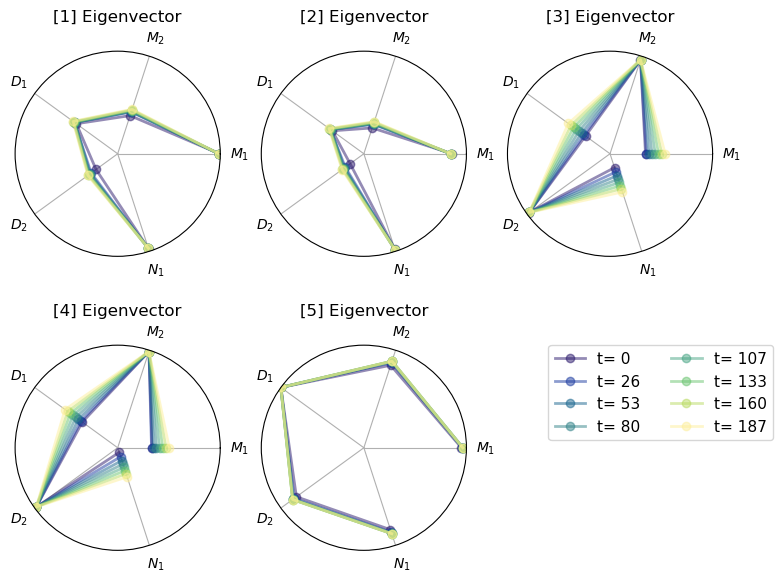

In [7]:
# Spider plot 
labels=['$M_1$', '$M_2$', '$D_1$', '$D_2$', '$N_1$']
labels = np.array(labels)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

fig, axs = plt.subplots(figsize=(9,7), nrows=2, ncols=3, subplot_kw=dict(polar=True), sharex= True, sharey=True) 
axs = axs.flatten()

for ax in axs:
    stats = np.array([1 , 2 , 3 , 4 , 5])
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.grid(True)
axs[-1].remove() 

for it in TIMES[::2]: 
    hour = dst.t.values[it]/3600
    d1 = dst.d1.values[it, id ,ir, ik]
    print(d1)
    d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir, ik] 
    m2 = dst.m2.values[it, id ,ir, ik]
    n1 = dst.n1.values[it, id ,ir, ik]
    print(m1)
    eigenvalues, ev = jacobian(kappa, h1, h2, m1, m2, d1, d2, n1)
    for iv, vector in enumerate(ev): 
        axs[iv].plot(angles, np.log(abs(vector)), 'o-', linewidth=2, label="t= %d" % hour, color=cmo.cm.haline(it/max(TIMES)), alpha=0.5)
        axs[iv].set_title("[%d] Eigenvector" % (iv+1))
axs[-2].legend(bbox_to_anchor=(1.4, 1), ncols=2, loc='upper left', borderaxespad=0., fontsize=11)


kappa = 3e-03
it = 0, hour = 0.0

kappa = 3e-03
it = 1, hour = 0.3

kappa = 3e-03
it = 2, hour = 0.7

kappa = 3e-03
it = 3, hour = 1.0
theta [134.25934723  45.90319146 134.07690867 134.12978714]
theta [ 44.2189476  135.94744877  44.03132665  44.08374789]
theta [90.0810236  90.04847984 90.00071479 90.04102945]
theta [90.00008125 89.99938829 89.95734082 89.99929023]
theta [90.35963117 89.53283088 90.5398897  90.56385203]

kappa = 1e-03
it = 0, hour = 0.0

kappa = 1e-03
it = 1, hour = 0.3

kappa = 1e-03
it = 2, hour = 0.7

kappa = 1e-03
it = 3, hour = 1.0
theta [133.38642011 133.40209665 133.34654025 133.31414983]
theta [43.22382158 43.22976382 43.16831997 43.1323891 ]
theta [90.00014959 90.05678622 90.0482677  90.04438402]
theta [89.91898058 89.99903229 89.99880128 89.99872765]
theta [90.53510391 90.87207901 91.00953502 91.09223915]

kappa = 6e-04
it = 0, hour = 0.0

kappa = 6e-04
it = 1, hour = 0.3

kappa = 6e-04
it = 2, hour = 0.7

kappa = 6e-04
it = 3, hour = 1.0
theta [132.05560878 

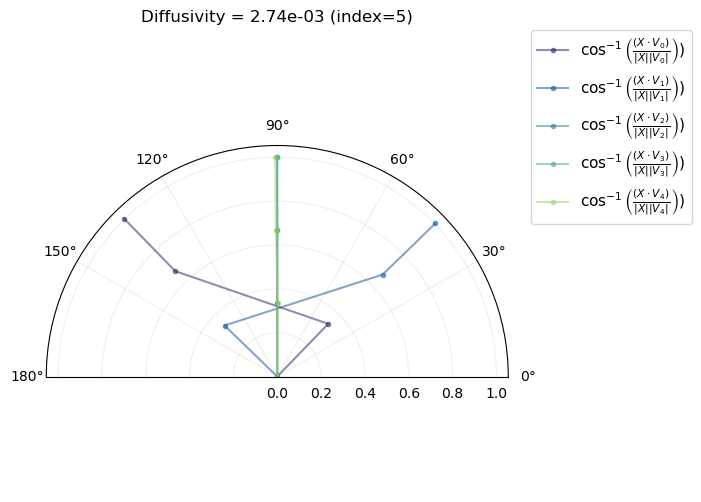

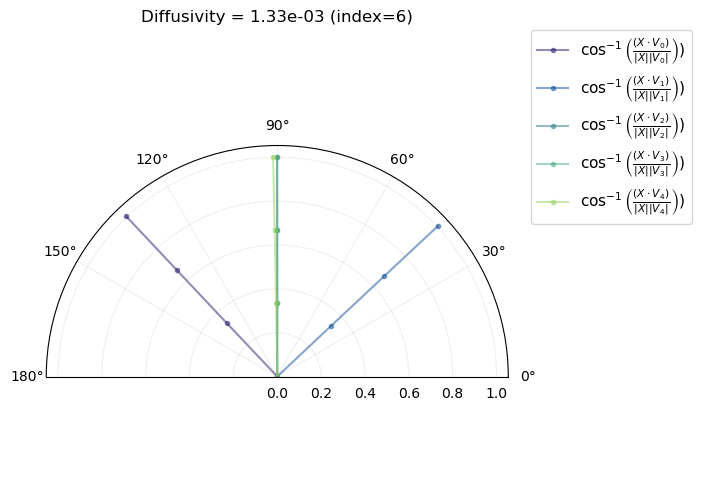

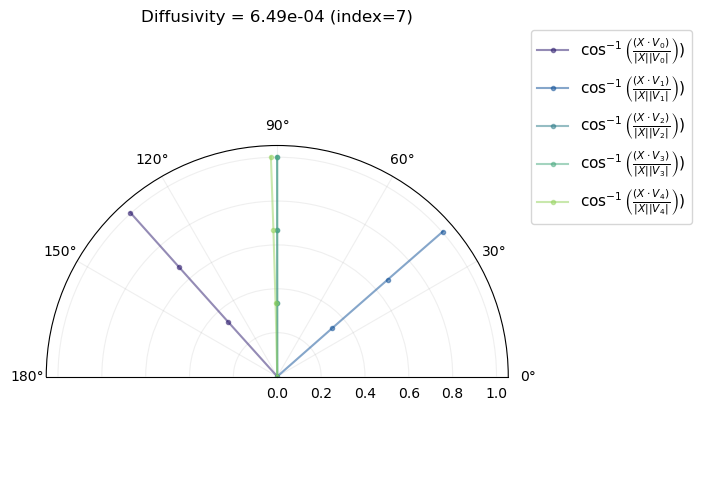

In [ ]:
# Polar plot
TIMES = list(range(0, 4, 1)) 

hours = [dst.t.values[i]/3600 for i in TIMES]
for ik in range(5, 8, 1):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='polar')

    ax.grid(alpha=0.2)

    ax.set_title("Diffusivity = %2.2e (index=%d)" % (dst.kappa.values[ik], ik))
    kappa = dst.kappa.values[ik]
    
    # d1 = dst.d1.values[0, id ,ir, ik] 
    # d2 = dst.d2.values[0, id ,ir, ik] # (time, depth, ratio, kappa) 
    # m1 = dst.m1.values[0, id ,ir, ik] 
    # m2 = dst.m2.values[0, id ,ir, ik]
    # n1 = dst.n1.values[0, id ,ir, ik] 
    # state_vector0 = np.array([m1, m2, d1, d2, n1])
    theta = np.zeros((len(TIMES), 5))

    for i, it in enumerate(TIMES): 

        hour = dst.t.values[it]/3600
        d1 = dst.d1.values[it, id ,ir, ik]
        d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
        m1 = dst.m1.values[it, id ,ir, ik]
        m2 = dst.m2.values[it, id ,ir, ik]
        n1 = dst.n1.values[it, id ,ir, ik]
        eigenvalues, ev = jacobian(kappa, h1, h2, m1, m2, d1, d2, n1)
        state_vector = np.array([m1, m2, d1, d2, n1])

        # Iterate through the eigenvectors
        for iv, vector in enumerate(ev): 
            cos0 =  np.dot(state_vector, vector) / (np.linalg.norm(state_vector) * np.linalg.norm(vector)) 
            # print(np.rad2deg(cos0)) 
            theta[i, iv]  = np.arccos(cos0)

        print("\nkappa = %1.0e" % kappa)  
        print("it = %d, hour = %2.1f" % (it, hour))

    for c in range(0,5):
        print("theta", np.rad2deg(theta[:,c])) 
        ax.plot(theta[:,c], hours, '.-', color=cmo.cm.haline(c/5), alpha=0.5, label=r'$\cos^{-1} \left( \frac{(X \cdot V_%d)}{ |X| |V_%d|} \right)$)' % (c,c)) # Theta= cos^-1 (u dot v / |v| |u|).
        # ax.plot(hours,theta[:,c], '-o', color=cmo.cm.deep(c/5), alpha=0.5, label=r'$\cos^{-1} \left( \frac{(X \cdot V_%d)}{ |X| |V_%d|} \right)$)' % (c,c)) # Theta= cos^-1 (u dot v / |v| |u|).

    ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11)
    ax.set_thetamin(0)
    ax.set_thetamax(180)

<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1809419/3071971378.py:24: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(hour, eigenvalue.real, 'o', label="$\lambda_%d$" % ie , color=cmo.cm.phase(ie/5))
/tmp/ipykernel_1809419/3071971378.py:24: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(hour, eigenvalue.real, 'o', label="$\lambda_%d$" % ie , color=cmo.cm.phase(ie/5))


ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

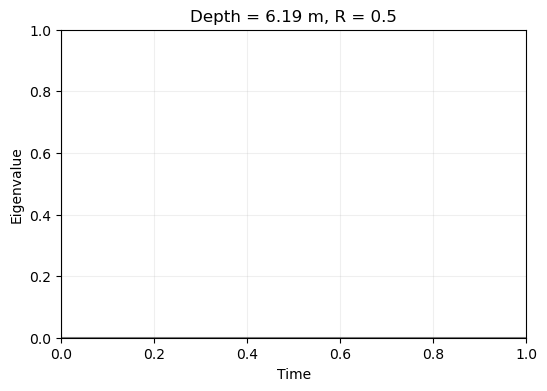

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.gca() 


variables = ["M_1", "M_2", "D_1", "D_2", "N_1"]

ax.grid(alpha=0.2)
ax.set_title(txt)
ax.axhline(y=0, color='k', alpha=0.5)
ax.axvline(x=0, color='k', alpha=0.5)
ax.set_ylabel("Eigenvalue")
ax.set_xlabel("Time")

for it in TIMES: 
    hour = dst.t.values[it]/3600
    d1 = dst.d1.values[it, id ,ir, ik]
    d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir, ik]
    m2 = dst.m2.values[it, id ,ir, ik]
    n1 = dst.n1.values[it, id ,ir, ik]
    eigenvalues = jacobian(kappa, h1, h2, m1, m2, d1, d2, n1)
    for ie, eigenvalue in enumerate(eigenvalues):
        if it == 0:
            ax.plot(hour, eigenvalue.real, 'o', label="$\lambda_%d$" % ie , color=cmo.cm.phase(ie/5))
        else:
            ax.plot(hour, eigenvalue.real, 'o',  color=cmo.cm.phase(ie/5))

# ax.set_ylim(-0.00001,)
ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=14)
fn = txt.replace(",", "_")
ax.set_yscale('symlog')
# fig.savefig("eigens/%s.png" % fn, dpi=300)

In [ ]:
colors = [ "#F2B707",  "#9F22F2", "#BF0F0F"]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharey=False, sharex=False)
hours = dst.t.values[:]/3600
axs[0].plot(hours, dst.d1.values[:, id ,ir, ik]/h1, label="D1", color=colors[0])
axs[0].plot(hours, dst.d2.values[:, id ,ir, ik]/h2, label="D2", color=colors[0], linestyle='--')
axs[0].plot(hours, dst.m1.values[:, id ,ir, ik]/h1, label="M1", color=colors[1])
axs[0].plot(hours, dst.m2.values[:, id ,ir, ik]/h2, label="M2", color=colors[1], linestyle='--')
axs[1].plot(hours, dst.n1.values[:, id ,ir, ik], label="N1", color=colors[2])
axs[0].set_ylabel("Phytoplankton")
axs[0].set_yscale("log")
axs[0].legend()
# d1 = dst.d1.values[it, id ,ir, ik]
# d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
# m1 = dst.m1.values[it, id ,ir, ik]
# m2 = dst.m2.values[it, id ,ir, ik]
# n1 = dst.n1.values[it, id ,ir, ik]